In [1]:
# others
import pandas as pd
import numpy as np
import argparse
from copy import deepcopy
import seaborn as sns 
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.model_selection import train_test_split

# pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import IPython
import IPython.display
 
print(torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

# read file
train_x_df = pd.read_csv('./data/train_x_df.csv')
train_y_df = pd.read_csv('./data/train_y_df.csv')
# df = pd.read_hdf('./data/merged_data.h5')

print('Read files Complete!')

1.6.0+cpu
Populating the interactive namespace from numpy and matplotlib
Read files Complete!


In [2]:
'''
Conv1d Input = (Batch, n_Features, Time_step)

arguments :
in_channels = feature dimension
out_channels = output dimension
kernel_size = time step size
'''
cov1 = nn.Conv1d(in_channels, out_channels, 
                 kernel_size, stride, padding, 
                 dilation, groups, bias, padding_mod

SyntaxError: unexpected EOF while parsing (<ipython-input-2-abdf22ed14d1>, line 1)

In [3]:
def df2d_to_array3d(df_2d):
    
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    
    return array_3d
# ================================================= #
train_x_df = train_x_df[train_x_df.coin_index == 9]
train_y_df = train_y_df[train_y_df.coin_index == 9]


train_x_arr = df2d_to_array3d(train_x_df)
train_y_arr = df2d_to_array3d(train_y_df)


print(
    f'''
    train x shape is {train_x_arr.shape},
    train y shape is {train_y_arr.shape}
    '''
)


    train x shape is (1208, 1380, 10),
    train y shape is (1208, 120, 10)
    


In [4]:
def simple_exponetial_smoothing(arr, alpha=0.3):
    
    y_series = list()
    
    for temp_arr in arr:
        target_series = temp_arr[:, 1].reshape(-1) # open col is 1 index

        smoother = SimpleExpSmoothing(target_series, initialization_method="heuristic").fit(smoothing_level=0.3,optimized=False)
        smoothing_series = smoother.fittedvalues
        
        y_series.append(smoothing_series)
    
    return np.array(y_series)

def moving_average(arr, window_size = 20):
    
    #length = ma 몇 할지
    length = window_size
    ma = np.zeros((arr.shape[0], arr.shape[1] - length, arr.shape[2]))

    for idx in range(arr.shape[0]):
        for i in range(length, arr.shape[1]):
            for col in range(arr.shape[2]):
                ma[idx, i-length, col] = arr[idx,i-length:i, col].mean() #open
            
    return ma[:, :, 1] # open col is 1


    original y series : train_y1_arr,
    moving average smoothing : train_y2_arr,
    simple exponetial smoothing : train_y3_arr
    


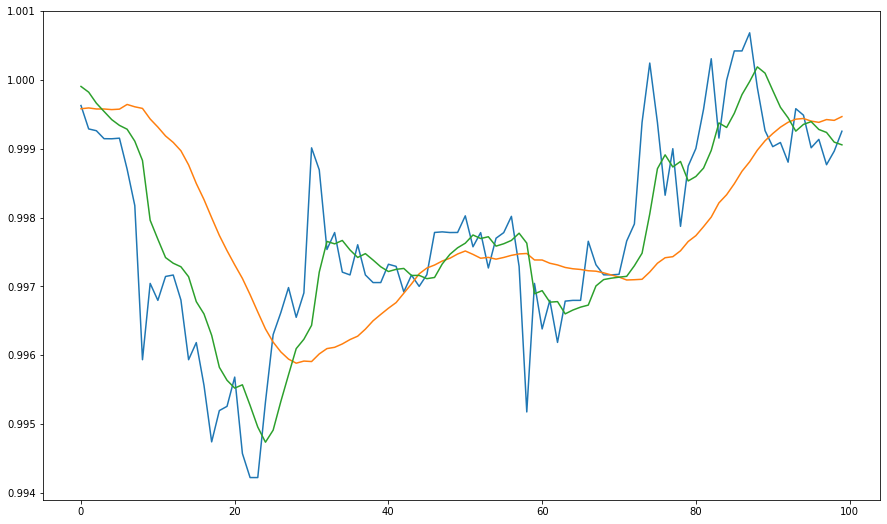

In [5]:
train_y1_arr = train_y_arr[:, :, 1] # open col is 1
train_y2_arr = moving_average(train_y_arr)
train_y3_arr = simple_exponetial_smoothing(train_y_arr)

print(
    f'''
    original y series : train_y1_arr,
    moving average smoothing : train_y2_arr,
    simple exponetial smoothing : train_y3_arr
    '''
)

for i in range(len(train_y1_arr)):
    
    plt.plot(train_y1_arr[i, -100:], label="origin")
    plt.plot(train_y2_arr[i, -100:], label="moving average")
    plt.plot(train_y3_arr[i, -100:], label="expoential")
    
    break

In [6]:
def train_val_test_spliter(arr):
    
    n = len(arr)
    num_features = arr.shape[2] - 1
    
    train_arr = arr[0:int(n*0.8), :, 1:]
    val_arr = arr[int(n*0.8):, :, 1:]
    
    n2 = len(train_arr) + len(val_arr)
    
    print(
    f'''
    ======================================================
    Origin length is {n}, then total split length is {n2}
    ======================================================
    train length is {train_arr.shape},
    val length is {val_arr.shape},
    num_features is ({num_features})
    '''
    )
    
    return train_arr, val_arr


In [7]:
train_x_arr, val_x_arr = train_val_test_spliter(train_x_arr)


    Origin length is 1208, then total split length is 1208
    train length is (966, 1380, 9),
    val length is (242, 1380, 9),
    num_features is (9)
    


In [8]:
train_x_mean = train_x_arr.mean(axis=(0, 1))
train_x_std = train_x_arr.std(axis=(0, 1))

train_x_arr = (train_x_arr - train_x_mean) / train_x_std
val_x_arr = (val_x_arr - train_x_mean) / train_x_std


In [9]:


train_y1_arr, val_y1_arr = train_test_split(train_y1_arr, test_size=0.2, shuffle=False)
train_y2_arr, val_y2_arr = train_test_split(train_y2_arr, test_size=0.2, shuffle=False)
train_y3_arr, val_y3_arr = train_test_split(train_y3_arr, test_size=0.2, shuffle=False)


In [10]:
print(
    f'''
    train x shape is {train_x_arr.shape},
    train y shape is {train_y1_arr.shape}, {train_y2_arr.shape}, {train_y3_arr.shape}
    
    val x shape is {val_x_arr.shape},
    val y shape is {val_y1_arr.shape}, {val_y2_arr.shape}, {val_y3_arr.shape}
    '''
)


    train x shape is (966, 1380, 9),
    train y shape is (966, 120), (966, 100), (966, 120)
    
    val x shape is (242, 1380, 9),
    val y shape is (242, 120), (242, 100), (242, 120)
    


In [21]:
# ====== initialization
parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device is",args.device)

seed = 777
np.random.seed(seed)
torch.manual_seed(seed)


# ====== Model Capacity options ===== #
args.input_dim = 9
args.hidden_dim = 100
args.output_dim = 1
args.n_layers = 1
args.batch_size = 64
args.dropout = 0.2
args.use_bn = True

# ====== Dataset Generating options ====== #
args.x_frames = 120
args.y_frames = 120

# ====== Model training options ===== #
args.num_epoch = 20
args.learning_rate = 0.01
args.L2_rate = 0.00001


device is cpu


In [22]:
class WindowGenerator():
    ''' Dataset Generate'''
    def __init__(self, X_arr, y_arr, x_frames):
    
        self.X_arr = X_arr
        self.y_arr = y_arr
        self.x_frames = x_frames
        
        
    def __repr__(self):
        return '\n'.join([
            f'Input indices: {self.X_arr.shape}',
            f'Label indices: {len(self.y_arr)}',
            f'Current column name(s): {self.x_frames}'
        ])

    def __len__(self):
        return len(self.y_arr)

    def __getitem__(self, idx):
        
        X = self.X_arr[idx, -self.x_frames:, :]
        y = self.y_arr[idx, :]

        return X, y

In [23]:
trainset = WindowGenerator(train_x_arr, train_y1_arr, x_frames = 255)
valset = WindowGenerator(val_x_arr, val_y1_arr, x_frames = 255)

partition = {'train': trainset, 'val':valset}

In [25]:
# pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [38]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, use_bn):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.dropout = dropout
        self.use_bn = use_bn 
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        self.regressor = self.make_regressor()
        
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim))
    
    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, X):
        lstm_out, self.hidden = self.lstm(X)
        y_pred = self.regressor(lstm_out[-1].view(X.shape[1], -1))
        return y_pred
    
    
def train(model, partition, optimizer, loss_fn, args):
    ''' model training '''
   
    # data load
    trainloader = DataLoader(partition['train'],
                             batch_size = args.batch_size,
                             shuffle = True, drop_last = True)
    
    # model's mode setting
    model.train()
    model.zero_grad()
    
    train_loss = 0.0
    
    for i, (X, y) in enumerate(trainloader):
    
        X = X.transpose(0, 1).float().to(args.device)
        y_true = y.float().to(args.device)
        
#         print(X.shape, y_true.shape)
        
        # zero the gradient
        optimizer.zero_grad()

        model.hidden = model.init_hidden(X.shape[1])

        y_pred = model(X)
#         print(y_pred.shape)
        
        loss = loss_fn(y_true.view(-1), y_pred.view(-1))
        loss.backward()
        optimizer.step()
        
        # get the batch loss
        train_loss += loss.item()
        
    train_loss = train_loss / len(trainloader)
    # train_loss = train_loss*10E5
    return model, train_loss


def validate(model, partition, loss_fn, args):
    ''' model validate '''
    
    # data load
    valloader = DataLoader(partition['val'], 
                           batch_size = args.batch_size, 
                           shuffle = False, drop_last = True)
    
    # model's mode setting
    model.eval()
    val_loss = 0.0
    
    # evaluate
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):
            
            X = X.transpose(0, 1).float().to(args.device)
            y_true = y.float().to(args.device)
            
            model.hidden = model.init_hidden(X.shape[1])
            # en-decoder outputs tensor 
            y_pred = model(X)
            # compute the loss 
            loss = loss_fn(y_true.view(-1), y_pred.view(-1))

            # get the batch loss
            val_loss += loss.item()
            
    val_loss = val_loss / len(valloader)
    # val_loss = val_loss * 10E5
    return val_loss



def experiment(partition, args):


    model = LSTM(args.input_dim, args.hidden_dim, args.y_frames, args.n_layers, args.dropout, args.use_bn)
    model.to(args.device)
    
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.L2_rate)
    
    # epoch-wise loss
    train_losses = []
    val_losses = []

    for epoch in range(args.num_epoch):
        
        start_time = time.time()
        model, train_loss = train(model, partition, optimizer, loss_fn, args)
        val_loss = validate(model, partition, loss_fn, args)
        end_time = time.time()
        
        # add epoch loss
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print('Epoch {},Loss(train/val) {:.3f}/{:.3f}. Took {:.2f} sec'.format(epoch+1, train_loss, val_loss, end_time-start_time))
    
    # test part
    # test_mae, item_loss_list = test(model, partition, scaler, args)
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    
    result['train_losses'] = train_losses #epoch 수에 의존
    result['val_losses'] = val_losses 
    
    #result['test_mae'] = test_mae.round(3).item()
    
    # result['r2'] = np.array(score_list).mean().round(3)
    # item_loss = np.array(item_loss_list).mean(axis=0).mean(axis=0).astype(int)
    # item_loss = list([int(x) for x in item_loss])
    # result['item_loss'] = item_loss
     
    return vars(args), result, model

In [39]:
IPython.display.clear_output()
setting, result, model = experiment(partition, deepcopy(args))

Epoch 1,Loss(train/val) 0.278/0.431. Took 11.65 sec
Epoch 2,Loss(train/val) 0.081/0.153. Took 9.97 sec
Epoch 3,Loss(train/val) 0.025/0.030. Took 10.49 sec
Epoch 4,Loss(train/val) 0.017/0.014. Took 12.73 sec


KeyboardInterrupt: 

In [ ]:
# 3차원 array로 변경
def df2d_to_array3d(df_2d):

    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

# 코인별 인덱스 뽑기
def coin_index_export(input_array, coin_num):

    index = []
    sample_id_len = input_array.shape[0]
    coin_num_col = 0 

    for sample_id in range(sample_id_len):
        if input_array[sample_id, 0, coin_num_col] == coin_num:
            #print(sample_id)
            index.append(sample_id)
    return index


# n분봉으로 나누는 함수
# idxsize= _array[0], time_size = _array[1], time_split = 몇분봉으로 나눌건지, arrayy = array명
def time_split(input_array, split_size = 6):

    # origin size define
    index_size = input_array.shape[0]
    origin_time_size = input_array.shape[1]
    variable_size = input_array.shape[2]

    # new array size define
    new_time_size = int(origin_time_size/split_size) # 1380 / 6
    new_array = np.zeros((index_size, new_time_size, variable_size))

    for idx in range(index_size):
        for time_idx in range(new_time_size):
            

            first_time_idx = time_idx * split_size
            last_time_idx = ((time_idx+1) * split_size) -1

            new_array[idx, time_idx, 0] = input_array[idx, first_time_idx, 0] #coin_num
            new_array[idx, time_idx, 1] = input_array[idx, first_time_idx, 1] #open
            
            new_array[idx, time_idx, 2] = np.max(input_array[idx, first_time_idx:last_time_idx, 2]) #high
            new_array[idx, time_idx, 3] = np.min(input_array[idx, first_time_idx:last_time_idx, 3]) #low

            new_array[idx, time_idx, 4] = input_array[idx, last_time_idx, 4] #close

            new_array[idx, time_idx, 5] = np.sum(input_array[idx, first_time_idx:last_time_idx, 5]) #etc
            new_array[idx, time_idx, 6] = np.sum(input_array[idx, first_time_idx:last_time_idx, 6]) #etc
            new_array[idx, time_idx, 7] = np.sum(input_array[idx, first_time_idx:last_time_idx, 7]) #etc
            new_array[idx, time_idx, 8] = np.sum(input_array[idx, first_time_idx:last_time_idx, 8]) #etc
            new_array[idx, time_idx, 9] = np.sum(input_array[idx, first_time_idx:last_time_idx, 9]) #etc

    return new_array
  
def create_datasettrain(signal_data, look_back):
  dataX, dataY = [], []
  for i in range(int(len(signal_data)-6)):
    dataX.append(signal_data[i-look_back:i])
    dataY.append(signal_data[i:i+6])
  dataX = dataX[look_back:]
  dataY = dataY[look_back:]
  return np.array(dataX), np.array(dataY)

def create_datasettest(signal_data, look_back):
  dataX = []
  for i in range(int(len(signal_data))):
    dataX.append(signal_data[i-look_back:i])
  dataX = dataX[look_back:]
  return np.array(dataX)

def feature_normalization_by_last_idx(input_array):

    # origin size define
    index_size = input_array.shape[0]
    origin_time_size = input_array.shape[1]
    variable_size = input_array.shape[2]
    last_time_idx = origin_time_size - 1
    # new array size define
    new_array = np.zeros((index_size, origin_time_size, variable_size))

    for idx in range(index_size):
            

        new_array[idx, :, 0] = input_array[idx, :, 0] #coin_num
        new_array[idx, :, 1] = input_array[idx, :, 1] #open
            
        new_array[idx, :, 2] = input_array[idx, :, 2] #high
        new_array[idx, :, 3] = input_array[idx, :, 3] #low

        new_array[idx, :, 4] = input_array[idx, :, 4] #close

        new_array[idx, :, 5] = input_array[idx, :, 5]/input_array[idx, last_time_idx, 5]#etc
        new_array[idx, :, 6] = input_array[idx, :, 6]/input_array[idx, last_time_idx, 6] #etc
        new_array[idx, :, 7] = input_array[idx, :, 7]/input_array[idx, last_time_idx, 7] #etc
        new_array[idx, :, 8] = input_array[idx, :, 8]/input_array[idx, last_time_idx, 8] #etc
        new_array[idx, :, 9] = input_array[idx, :, 9]/input_array[idx, last_time_idx, 9] #etc

    return new_array

In [ ]:
''' greedy feature handleing'''
# test_df = train_x_df[train_x_df['volume'] != 0]
# test_df['rest_asset'] = test_df['volume'] - test_df['tb_base_av']
# test_df['greedy'] = test_df['tb_base_av'] / test_df['volume']

# test_df2 = test_df[['time', 'coin_index', 'open', 'high', 'low', 'close', 'volume', 'trades', 'tb_base_av','rest_asset', 'greedy']]
# test_df2[['coin_index','trades', 'volume', 'tb_base_av','rest_asset', 'greedy']].head()
# test_df2[test_df2['greedy'] == 1][['coin_index','trades', 'volume', 'tb_base_av','rest_asset', 'greedy']].head()

In [ ]:
train_df = df[df.sample_id < 100]
# val_df = df[(df.sample_id >= 1000) & (df.sample_id < 1108)]
# test_df = df[df.sample_id >= 1108]

# 개수 체크
# print(
#     f'''
#     train set is {len(train_df) / 1500}
#     val set is {len(val_df) / 1500}
#     test set is {len(test_df)/1500}
#     '''
# )

In [ ]:
new_df = pd.DataFrame()

In [ ]:
new_df

In [ ]:

grouped_df = df.groupby('sample_id')
unique_sample_id_list = grouped_df.sample_id.unique()
new_df = pd.DataFrame()

for sample_id in unique_sample_id_list:

    # get one sample_id in sample list
    temp_sample_id = sample_id.item()
    # get one group by temp_sample_id
    temp_df = grouped_df.get_group(temp_sample_id)

    rolling = temp_df.loc[:, ['open', 'high', 'low', 'close','volume', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av']].rolling(window = 10)
    temp_df.loc[:, ['open', 'high', 'low', 'close','volume', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av']] = rolling.mean()
    temp_df = temp_df.dropna()
    
    new_df = pd.concat([new_df, temp_df])

In [ ]:
new_df

In [ ]:
temp_df.open.plot(np.arange(0,120))
rolling_mean.plot(x=(0,120),color='red')
plt.show()

In [ ]:
# ====== Generating Dataset ====== #

def data_generate(dataframe, x_frames, y_frames, print_mode = False):

    ''' 설명 생략 '''

    # grouping
    grouped_df = dataframe.groupby('sample_id')
    
    # export unique sample ids
    unique_sample_id_list = grouped_df.sample_id.unique()

    # create new lists
    X, y = list(), list()

    ''' 샘플 하나 선택 loop '''
    for sample_id in unique_sample_id_list:
        
        # get one sample_id in sample list
        temp_sample_id = sample_id.item()

        # get one group by temp_sample_id
        temp_df = grouped_df.get_group(temp_sample_id)

        # 한 샘플당 몇 개의 arrset가 나오는 지 확인
        count = 0
        split_length = len(temp_df) - (x_frames + y_frames) + 1
        
        ''' 한 샘플 내 데이터 split loop '''
        for time_idx in range(split_length):
            
            # index 변경
            time_idx += x_frames
            
            # temp_data select
            temp_arr = temp_df.iloc[time_idx - x_frames : time_idx + y_frames, 3:].values

            # get values
            temp_x = temp_arr[:x_frames, :]
            temp_y = temp_arr[x_frames:, :]

#             # 2d to 3d -> (255, 12) to (1, 255, 12) / (120, 12) to (1, 120, 12)
#             temp_3d_x = np.expand_dims(temp_2d_x, axis = 0)
#             temp_3d_y = np.expand_dims(temp_2d_y, axis = 0)
            
            # appending
            X.append(temp_x)
            y.append(temp_y)
            
            # counter printing
            count += 1
            if (count == split_length) & (print_mode == True):
                print(f'현재 sample id : {temp_sample_id}')
                print(f'{temp_sample_id}번째 sample의 생성 array수 : {count}')
            
    return np.array(X), np.array(y)

In [ ]:
# ====== Generating Dataset ====== #

def open_data_generate(dataframe, col_name, x_frames, y_frames, print_mode = False):

    ''' 설명 생략 '''

    # grouping
    grouped_df = dataframe.groupby('sample_id')
    
    # export unique sample ids
    unique_sample_id_list = grouped_df.sample_id.unique()

    # create new lists
    X, y = list(), list()

    ''' 샘플 하나 선택 loop '''
    for sample_id in unique_sample_id_list:
        
        # get one sample_id in sample list
        temp_sample_id = sample_id.item()

        # get one group by temp_sample_id
        temp_series = grouped_df.get_group(temp_sample_id)[col_name]

        # 한 샘플당 몇 개의 arrset가 나오는 지 확인
        count = 0
        split_length = len(temp_series) - (x_frames + y_frames) + 1
        
        ''' 한 샘플 내 데이터 split loop '''
        for time_idx in range(split_length):
            
            # index 변경
            time_idx += x_frames
            
            # temp_data select
            temp_arr = temp_series[time_idx - x_frames : time_idx + y_frames]

            # get values
            temp_x, temp_y = temp_arr.iloc[:x_frames].values, temp_arr.iloc[x_frames:].values

            # appending
            X.append(temp_x)
            y.append(temp_y)
            
            # counter printing
            count += 1
            if (count == split_length) & (print_mode == True):
                print(f'현재 sample id : {temp_sample_id}')
                print(f'{temp_sample_id}번째 sample의 생성 array수 : {count}')
            
    return np.array(X), np.array(y)